In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
def LoadBatch(file):
    X = unpickle(file)[b'data'].T / 255 # Normalised image inputs
    y = unpickle(file)[b'labels'] # Output labels
    Y = one_hot(y) # One hot encoded output labels
    return X, y, Y

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(labels, number_distinct_labels=10):
    labels_one_hot = np.zeros(shape=(number_distinct_labels,len(labels)))
    for i, label in enumerate(labels):
        labels_one_hot[label,i] = 1
    return labels_one_hot

## Preparing the data

In [3]:
# Training data
X_1, y_1, Y_1 = LoadBatch('cifar-10-batches-py/data_batch_1') # X = data, y = labels, Y = one hot
X_2, y_2, Y_2 = LoadBatch('cifar-10-batches-py/data_batch_2')
X_3, y_3, Y_3 = LoadBatch('cifar-10-batches-py/data_batch_3')
X_4, y_4, Y_4 = LoadBatch('cifar-10-batches-py/data_batch_4')
X_5, y_5, Y_5 = LoadBatch('cifar-10-batches-py/data_batch_5')

X_test, y_test, Y_test = LoadBatch('cifar-10-batches-py/test_batch')

X = np.hstack((X_1, X_2, X_3, X_4, X_5))
y = y_1 + y_2 + y_3 + y_4 + y_5
Y = np.hstack((Y_1, Y_2, Y_3, Y_4, Y_5))

# Get 5000 images for validation set
np.random.seed(0)
idx_val = np.random.choice(range(X.shape[1]), 5000, replace=False)
X_val = X[:,idx_val]
y_val = [y[i] for i in idx_val]
Y_val = Y[:,idx_val]

# Keep 45000 images for training set
X_train = np.delete(X, idx_val, 1)
y_train = [y[i] for i in range(X.shape[1]) if i not in idx_val]
Y_train = np.delete(Y, idx_val, 1)

# Data normalization
std = X_train.std(axis=1).reshape(X_train.shape[0], 1)
mean = X_train.mean(axis=1).reshape(X_train.shape[0], 1)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

print("--- Training ---")
print(X_train.shape)
print(len(y_train))
print(Y_train.shape)
print("\n--- Validation ---")
print(X_val.shape)
print(len(y_val))
print(Y_val.shape)
print("\n--- Test ---")
print(X_test.shape)
print(len(y_test))
print(Y_test.shape)

--- Training ---
(3072, 45000)
45000
(10, 45000)

--- Validation ---
(3072, 5000)
5000
(10, 5000)

--- Test ---
(3072, 10000)
10000
(10, 10000)


In [4]:
def initialize_weights(input_dim, hidden_dim, output_dim, seed=42, he = True, sigma = None):
    
    k = len(hidden_dim) + 1 # k layers
    
    W = [None]*k
    b = [None]*k
    γ = [None]*(k-1)
    β = [None]*(k-1)
    nodes = [input_dim] + hidden_dim + [output_dim]
    
    np.random.seed(seed)
    
    for layer in range(k):
                     
        # Weight initialising
        if sigma is not None:
            W[layer] = np.random.normal(0, sigma, (nodes[layer+1], nodes[layer]))
        elif he is True:
            W[layer] = np.random.normal(0, np.sqrt(2/nodes[layer]), (nodes[layer+1], nodes[layer]))
        else:
            W[layer] = np.random.normal(0, np.sqrt(1/nodes[layer]), (nodes[layer+1], nodes[layer]))
        
        # Bias initializing
        b[layer] = np.zeros((nodes[layer+1], 1))
        
        if layer < (k-1):
            γ[layer] = np.ones((nodes[layer+1], 1))
            β[layer] = np.zeros((nodes[layer+1], 1))
        
    return W, b, γ, β

In [5]:
input_dim = X_train.shape[0]
hidden_dim = [50,100]
output_dim = Y_train.shape[0]
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

In [6]:
len(W), len(b), len(γ), len(β)

(3, 3, 2, 2)

In [7]:
for i in range(len(hidden_dim) + 1):
    if i < len(hidden_dim):
        print("Layer", i, ":", W[i].shape, b[i].shape, γ[i].shape, β[i].shape)
    else: 
        print("Layer", i, ":", W[i].shape, b[i].shape)       

#W[0].shape, b[0].shape, γ[0].shape, β[0].shape

Layer 0 : (50, 3072) (50, 1) (50, 1) (50, 1)
Layer 1 : (100, 50) (100, 1) (100, 1) (100, 1)
Layer 2 : (10, 100) (10, 1)


In [8]:
def softmax(S):
    return np.exp(S) / np.exp(S).sum(axis=0)

def ReLu(S):
    H = S
    H[H<0] = 0
    return H

def EvaluateClassifier(X, W, b, γ = None, β = None, mean=None, var=None, batch_norm = False):

    k = len(W)
    X_l =[X.copy()]+[None]*(k-1)
    S = [None]*(k-1)
    S_bn = [None]*(k-1) 
    var_mean = False
    
    if batch_norm is True:
        if mean is None and var is None:
            var_mean = True
            mean, var = [None]*(k-1), [None]*(k-1)
    
    for layer in range(k-1):
       
        S[layer] = np.matmul(W[layer], X_l[layer]) + b[layer]
        if batch_norm is True:
            if var_mean is True:
                mean[layer] = S[layer].mean(axis=1).reshape(-1,1)
                var[layer] = S[layer].var(axis=1).reshape(-1,1)
            S_bn[layer] = (S[layer]-mean[layer])/(np.sqrt(var[layer]+1e-15))
            S_BatchNorm_Scaled = S_bn[layer]*γ[layer]+β[layer]
            X_l[layer+1] = ReLu(S_BatchNorm_Scaled)
        else:
            X_l[layer+1] = ReLu(S[layer])
            
    P = softmax(np.matmul(W[k-1], X_l[k-1]) + b[k-1])
                          
    if batch_norm is True and var_mean is True:
        return P, S_bn, S, X_l[1:], mean, var
    elif batch_norm is True:
        return P, S_bn, S, X_l[1:]
    else:
        return P, X_l[1:]

In [9]:
P, S_bn, S, X_l, mean, var = EvaluateClassifier(X_train[:,0:150], W, b, γ, β, 
                                                     mean=None, var=None, batch_norm=True)

In [10]:
P.shape, len(S_bn), len(S), len(X_l), len(mean), len(var)

((10, 150), 2, 2, 2, 2, 2)

In [11]:
def ComputeCost(X, Y, λ, W, b, γ = None, β = None, mean=None, var=None, batch_norm = False):
    
    if batch_norm is True and mean is None and var is None:
        P, S_bn, S, X_l, mean, var = EvaluateClassifier(X, W, b, γ, β, batch_norm = True)
    elif batch_norm is True:
        P, S_bn, S, X_l = EvaluateClassifier(X, W, b, γ, β, mean, var, batch_norm = True)      
    else:
        P, X_l = EvaluateClassifier(X, W, b)
    
    # Compute the loss function term
    l_cross = (-np.log((Y*P).sum(axis=0))).sum()
    
    # Compute the regularization term
    l_reg = 0
    
    for W_l in W:
        l_reg = l_reg + λ*((W_l**2).sum())
    
    # Return cost
    return l_cross/X.shape[1] + l_reg

In [12]:
def ComputeAccuracy(X, y, W, b, γ = None, β = None, mean = None, var = None, batch_norm = False):
    
    if batch_norm is True and mean is None and var is None:
        P, S_bn, S, X_l, mean, var = EvaluateClassifier(X, W, b, γ, β, batch_norm = True)
    elif batch_norm is True:
        P, S_bn, S, X_l = EvaluateClassifier(X, W, b, γ, β, mean, var, batch_norm = True)
    else:
        P, X_l = EvaluateClassifier(X, W, b)
    
    # Return accuracy
    return np.mean(y==np.argmax(P, 0))

In [13]:
def BatchNormBackPass(G, S, mean, var):
    
    G_1 = G*(np.matmul(((var+1e-15)**(-0.5)), np.ones((1, S.shape[1]))))
    G_2 = G*(np.matmul(((var+1e-15)**(-1.5)), np.ones((1, S.shape[1]))))
    
    d = S-np.matmul(mean, np.ones((1, S.shape[1])))
    c = np.matmul((G_2*d), np.ones((S.shape[1], 1)))
    
    return G_1-(np.matmul(G_1, np.ones((S.shape[1],1))))/S.shape[1]-d*(np.matmul(c, np.ones((1,S.shape[1]))))/S.shape[1]

def ComputeGradients(X, Y, P, S_bn, S, X_l, W, b, γ, β, mean, var, λ, batch_norm):

    # layer gradients
    k = len(W)
    grad_W = [None]*k
    grad_b = [None]*k
    grad_γ = [None]*(k-1)
    grad_β = [None]*(k-1)

    X_copy = X.copy()
    X_l = [X_copy] + X_l
    G = P-Y
    grad_W[k-1] = np.matmul(G, X_l[k-1].T)/X.shape[1]+2*λ*W[k-1]
    grad_b[k-1] = np.matmul(G, np.ones((X.shape[1],1)))/X.shape[1]
    G = np.matmul(W[k-1].T, G)
    G = G*(X_l[k-1]>0)
    
    for layer in range(k-2, -1, -1):
        if batch_norm is True:
            grad_γ[layer] = np.matmul((G*S_bn[layer]), np.ones((X.shape[1],1)))/X.shape[1]
            grad_β[layer] = np.matmul(G, np.ones((X.shape[1],1)))/X.shape[1]
            G = G*np.matmul(γ[layer], np.ones((1,X.shape[1])))
            G = BatchNormBackPass(G, S[layer], mean[layer], var[layer])
        
        grad_W[layer] = np.matmul(G, X_l[layer].T)/X.shape[1]+2*λ*W[layer]
        grad_b[layer] = np.matmul(G, np.ones((X.shape[1],1)))/X.shape[1]
        
        if layer > 0:
            G = np.matmul(W[layer].T, G)
            G = G*(X_l[layer] > 0)
        
    if batch_norm:
        return grad_W, grad_b, grad_γ, grad_β
    else:
        return grad_W, grad_b

In [14]:
def ComputeGradsNum(X, Y, λ, W, b, γ, β, mean, var, batch_norm, h=0.000001):
    
    # Create lists for saving the gradients by layers
    grad_W = [W_l.copy() for W_l in W]
    grad_b = [b_l.copy() for b_l in b]
    if batch_norm:
        grad_γ = [γ_l.copy() for γ_l in γ]
        grad_β = [β_l.copy() for β_l in β]
    
    # Compute initial cost and iterate layers k
    c = ComputeCost(X, Y, λ, W, b, γ, β, mean, var, batch_norm)
    k = len(W)
    for l in range(k):
        
        # Gradients for bias
        for i in range(b[l].shape[0]):
            b_try = [b_l.copy() for b_l in b]
            b_try[l][i,0] += h
            c2 = ComputeCost(X, Y, λ, W, b_try, γ, β, mean, var, batch_norm)
            grad_b[l][i,0] = (c2-c)/h
        
        # Gradients for weights
        for i in range(W[l].shape[0]):
            for j in range(W[l].shape[1]):
                W_try = [W_l.copy() for W_l in W]
                W_try[l][i,j] += h
                c2 = ComputeCost(X, Y, λ, W_try, b, γ, β, mean, var, batch_norm)
                grad_W[l][i,j] = (c2-c)/h
                
        if l<(k-1) and batch_norm:
            
            # Gradients for γ
            for i in range(γ[l].shape[0]):
                γ_try = [γ_l.copy() for γ_l in γ]
                γ_try[l][i,0] += h
                c2 = ComputeCost(X, Y, λ, W, b, γ_try, β, mean, var, batch_norm)
                grad_γ[l][i,0] = (c2-c)/h
            
            # Gradients for βs
            for i in range(β[l].shape[0]):
                β_try = [β_l.copy() for β_l in β]
                β_try[l][i,0] += h
                c2 = ComputeCost(X, Y, λ, W, b, γ, β_try, mean, var, batch_norm)
                grad_β[l][i,0] = (c2-c)/h
    
    if batch_norm:
        return grad_W, grad_b, grad_γ, grad_β
    else:
        return grad_W, grad_b

## Exercise 1: Computing analytical gradients

In [15]:
X = X_train[0:20,0:5]
Y = Y_train[:,0:5]
λ = 0

#### 2 layers

In [16]:
# Initialize weitghs
input_dim = X.shape[0]
hidden_dim = [50]
output_dim = Y.shape[0]
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Compute the gradients numerically
grad_W_num, grad_b_num = ComputeGradsNum(X, Y, λ, W, b, γ=None, β=None, mean=None, var=None, batch_norm=False)

# Compute the gradients analytically
P, X_l = EvaluateClassifier(X, W, b)
grad_W_ana, grad_b_ana = ComputeGradients(X=X, Y=Y, P=P, S_bn=None, S=None, X_l=X_l, W=W, b=b, 
                                          γ=None, β=None, mean=None, var=None, λ=λ, batch_norm=False)
                                
# Absolute error between both gradients
grad_W_abs_diff = [np.mean(np.abs(grad_W_ana[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W_ana))]
grad_b_abs_diff = [np.mean(np.abs(grad_b_ana[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b_ana))]

W_max_error = [np.max(np.abs(grad_W_ana[i]-grad_W_num[i])) for i in range(len(grad_W_ana))]
b_max_error = [np.max(np.abs(grad_b_ana[i]-grad_b_num[i])) for i in range(len(grad_b_ana))]

print("Percentage of weight errors < 1e-6:", grad_W_abs_diff)
print("Percentage of bias errors < 1e-6:", grad_b_abs_diff)
print("Max weight error:", W_max_error)
print("Max bias error:", b_max_error)

Percentage of weight errors < 1e-6: [100.0, 99.6]
Percentage of bias errors < 1e-6: [100.0, 100.0]
Max weight error: [3.1077043632921075e-08, 1.3130278271322737e-06]
Max bias error: [2.0072670636750445e-08, 8.831480199922304e-08]


#### 3 layers

In [17]:
# Initialize weitghs
hidden_dim = [50,50]
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Compute the gradients numerically
grad_W_num, grad_b_num = ComputeGradsNum(X, Y, λ, W, b, γ=None, β=None, mean=None, var=None,
                                         batch_norm=False)

# Compute the gradients analytically
P, X_l = EvaluateClassifier(X, W, b)
grad_W_ana, grad_b_ana = ComputeGradients(X=X, Y=Y, P=P, S_bn=None, S=None, X_l=X_l, W=W, b=b, 
                                  γ=None, β=None, mean=None, var=None, λ=λ,
                                  batch_norm=False)

# Absolute error between both gradients
grad_W_abs_diff = [np.mean(np.abs(grad_W_ana[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W_ana))]
grad_b_abs_diff = [np.mean(np.abs(grad_b_ana[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b_ana))]

W_max_error = [np.max(np.abs(grad_W_ana[i]-grad_W_num[i])) for i in range(len(grad_W_ana))]
b_max_error = [np.max(np.abs(grad_b_ana[i]-grad_b_num[i])) for i in range(len(grad_b_ana))]

print("Percentage of weight errors < 1e-6:", grad_W_abs_diff)
print("Percentage of bias errors < 1e-6:", grad_b_abs_diff)
print("Max weight error:", W_max_error)
print("Max bias error:", b_max_error)

Percentage of weight errors < 1e-6: [100.0, 100.0, 100.0]
Percentage of bias errors < 1e-6: [100.0, 100.0, 100.0]
Max weight error: [2.1835888958099403e-08, 2.3035743212940218e-07, 3.1549580603584815e-07]
Max bias error: [1.723493928129649e-08, 2.5528482244796535e-08, 7.017868716707731e-08]


#### 4 layers

In [18]:
# Initialize weitghs
hidden_dim = [50,50,10]
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Compute the gradients numerically
grad_W_num, grad_b_num = ComputeGradsNum(X, Y, λ, W, b, γ=None, β=None, mean=None, var=None,
                                         batch_norm=False)

# Compute the gradients analytically
P, X_l = EvaluateClassifier(X, W, b)
grad_W_ana, grad_b_ana = ComputeGradients(X=X, Y=Y, P=P, S_bn=None, S=None, X_l=X_l, W=W, b=b, 
                                  γ=None, β=None, mean=None, var=None, λ=λ,
                                  batch_norm=False)

# Absolute error between both gradients
grad_W_abs_diff = [np.mean(np.abs(grad_W_ana[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W_ana))]
grad_b_abs_diff = [np.mean(np.abs(grad_b_ana[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b_ana))]

W_max_error = [np.max(np.abs(grad_W_ana[i]-grad_W_num[i])) for i in range(len(grad_W_ana))]
b_max_error = [np.max(np.abs(grad_b_ana[i]-grad_b_num[i])) for i in range(len(grad_b_ana))]

print("Percentage of weight errors < 1e-6:", grad_W_abs_diff)
print("Percentage of bias errors < 1e-6:", grad_b_abs_diff)
print("Max weight error:", W_max_error)
print("Max bias error:", b_max_error)

Percentage of weight errors < 1e-6: [100.0, 100.0, 100.0, 100.0]
Percentage of bias errors < 1e-6: [100.0, 100.0, 100.0, 100.0]
Max weight error: [5.4356530554411364e-08, 6.34607092209194e-07, 5.68887205787405e-07, 5.398578817317201e-07]
Max bias error: [4.850460477712204e-08, 5.495565486013376e-08, 1.226303896206815e-07, 1.0257734145424635e-07]


## Exercise 2: train networks with different layers without batch normalisation

In [19]:
def MiniBatchGD(X, Y, y, GDparams, λ, W, b, γ=None, β=None, X_val=None, Y_val=None,
                y_val=None, batch_norm=False, α=0.9):
    
    n_batch = GDparams['n_batch']
    n_cycles = GDparams['cycles']
    step_size = GDparams['step_size']
    eta_min = GDparams['eta_min']
    eta_max = GDparams['eta_max']
    eta_min_max = eta_max-eta_min
        
    # metrics
    updates = []
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []
    
    X_original = X.copy()
    Y_original = Y.copy()
    y_original = y.copy()
    
    data_batches = {}
    for j in range(X.shape[1]//n_batch):            
        j_start = j*n_batch
        j_end = (j+1)*n_batch
        inds = range(j_start, j_end)
        data_batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
           
    grad_W = [W_l.copy() for W_l in W]
    grad_b = [b_l.copy() for b_l in b]
    
    if batch_norm is True:
        grad_γ = [γ_l.copy() for γ_l in γ]
        grad_β = [β_l.copy() for β_l in β]
    
    batch_index = 0
    # Iterate through the cycles
    for cycle in range(n_cycles):
        
        incr_cycle = 2*cycle*step_size
        decr_cycle = 2*(cycle+1)*step_size
        half_cycle = (2*cycle+1)*step_size
        
        # Iterate update steps
        for i in range(incr_cycle, 2*(cycle+1)*step_size):
                          
            # Increasing half of eta cycle
            if i >= incr_cycle and i < half_cycle:
                eta = eta_min+(i-incr_cycle)/step_size*eta_min_max
            # Decreasing half of eta cycle
            elif i >= half_cycle and i < decr_cycle:
                eta = eta_max-(i-half_cycle)/step_size*eta_min_max
            
            # Forward pass
            X_batch, Y_batch, y_batch = data_batches[batch_index]
            if batch_norm is True:
                P, S_bn, S, X_l, mean, var = EvaluateClassifier(X_batch, W, b, γ, β, batch_norm=True)
            else:
                P, X_l = EvaluateClassifier(X_batch, W, b)            

            # Setting average mean and var
            if cycle == 0 and i == 0 and batch_norm is True:
                mean_avg = mean
                var_avg = var
            elif batch_norm is True:
                mean_avg = [α*mean_avg[l]+(1-α)*mean[l] for l in range(len(mean))]
                var_avg = [α*var_avg[l]+(1-α)*var[l] for l in range(len(var))]
            else:
                mean_avg = None
                var_avg = None

            # Gradients
            if batch_norm is True:
                grad_W, grad_b, grad_γ, grad_β = ComputeGradients(X_batch, Y_batch, P, S_bn, S, X_l, W, b, γ, β, mean, var,
                                                                         λ, batch_norm=True)
            else:
                grad_W, grad_b = ComputeGradients(X_batch, Y_batch, P, S_bn=None, S=None, X_l=X_l, W=W, b=b, 
                                                  γ=None, β=None, mean=None, var=None, λ=λ,
                                                  batch_norm=False)
            
            # Update weights and biases
            W = [W[l]-eta*grad_W[l] for l in range(len(W))]
            b = [b[l]-eta*grad_b[l] for l in range(len(b))]
            if batch_norm is True:
                γ = [γ[l]-eta*grad_γ[l] for l in range(len(γ))]
                β = [β[l]-eta*grad_β[l] for l in range(len(β))]
            
            batch_index += 1
            
            if batch_index > X.shape[1]//n_batch-1:
            
                # Save learning metrics for plotting
                updates.append(i+1)
                acc_train.append(ComputeAccuracy(X, y, W, b, γ, β, mean_avg, var_avg, batch_norm))
                loss_train.append(ComputeCost(X, Y, λ, W, b, γ, β, mean_avg, var_avg, batch_norm))
                acc_val.append(ComputeAccuracy(X_val, y_val, W, b, γ, β, mean_avg, var_avg, batch_norm))
                loss_val.append(ComputeCost(X_val, Y_val, λ, W, b, γ, β, mean_avg, var_avg, batch_norm))                                    
                
                # Logging
                sys.stdout.write("Update: " + str(i+1) + ", Epoch: " +  str(len(updates)-1) + 
                                 " -> training loss:" + str(loss_train[-1]) + ", training accuracy:" + str(acc_train[-1]) + "\r")
                
                # Suffle data and create new batches for the next epoch (after all batches computed)
                #np.random.seed(i)
                permuted_indexes = np.random.permutation(X.shape[1])
                X = X_original[:,permuted_indexes]
                Y = Y_original[:,permuted_indexes]
                y = [y_original[index] for index in permuted_indexes]
                
                data_batches = {}
                for j in range(X.shape[1]//n_batch):            
                    j_start = j*n_batch
                    j_end = (j+1)*n_batch
                    inds = range(j_start, j_end)
                    data_batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
                    
                batch_index = 0
        
    if batch_norm is True:
        return W, b, γ, β, mean_avg, var_avg, updates, acc_train, loss_train, acc_val, loss_val
    else:
        return W, b, updates, acc_train, loss_train, acc_val, loss_val

In [20]:
# Function to plot the loss and accuracy learning curves
def plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val, check = False):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('Learning curves')
    
    if check == True:
        ax1.plot(updates, loss_train, label = "Training loss", color = "green")
        ax2.plot(updates, acc_train, label = "Training accuracy", color = "green")
    else:
        ax1.plot(updates, loss_train, label = "Training loss", color = "green")
        ax2.plot(updates, acc_train, label = "Training accuracy", color = "green")
        ax1.plot(updates, loss_val, label = "Validation loss", color = "red")   
        ax2.plot(updates, acc_val, label = "Validation accuracy", color = "red")
    
    ax1.set_xlabel("Updates")
    ax2.set_xlabel("Updates")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    
    ax1.grid(True)
    ax2.grid(True)
    ax1.legend()
    ax2.legend()

In [21]:
input_dim = X_train.shape[0]
hidden_dim = [50]
output_dim = Y_train.shape[0]

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)
β[0].shape

(50, 1)

#### 2 layers

In [22]:
input_dim = X_train.shape[0]
hidden_dim = [50]
output_dim = Y_train.shape[0]

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Define the network parameters
λ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, updates, acc_train, loss_train, acc_val, loss_val = MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, 
                                                                      X_val=X_val, Y_val=Y_val, y_val=y_val, batch_norm=False)

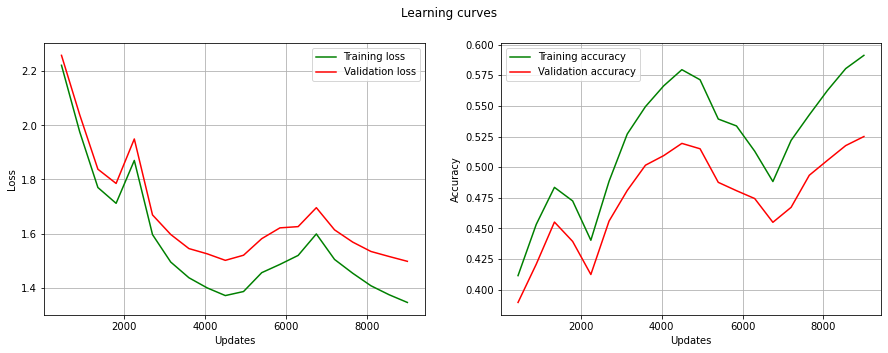

In [23]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

#### 3 layers

In [24]:
hidden_dim = [50,50]

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Train the network
W, b, updates, acc_train, loss_train, acc_val, loss_val = MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, 
                                                                      X_val=X_val, Y_val=Y_val, y_val=y_val, batch_norm=False)

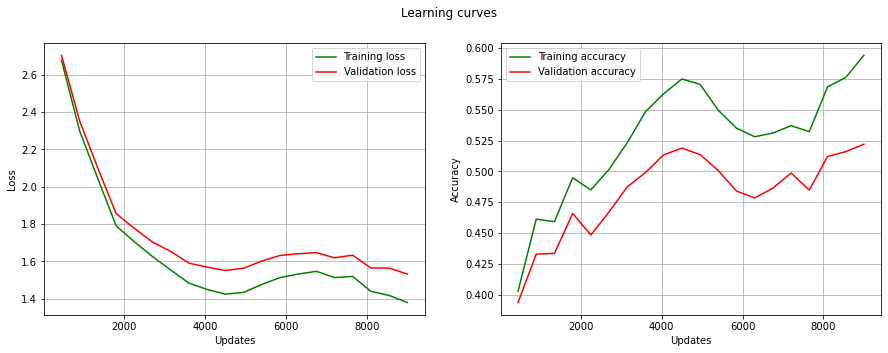

In [25]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

In [26]:
print(acc_val[-1])

0.522


#### 9 layers

In [27]:
hidden_dim = [50,30,20,20,10,10,10,10]

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Train the network
W, b, updates, acc_train, loss_train, acc_val, loss_val = MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, 
                                                                      X_val=X_val, Y_val=Y_val, y_val=y_val, batch_norm=False)

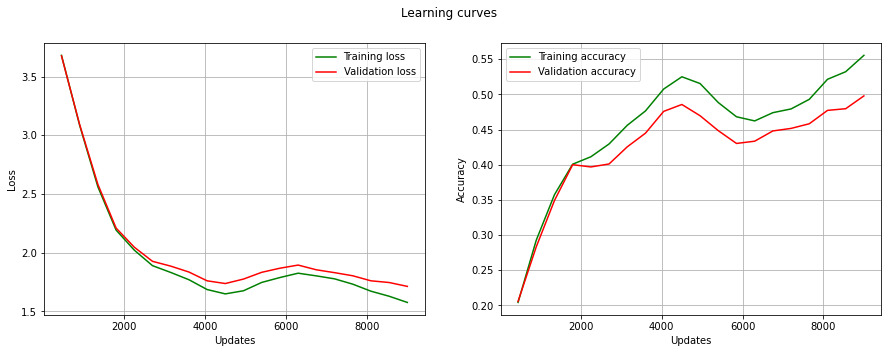

In [28]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

In [29]:
print(acc_val[-1])

0.4978


## Exercise 3: implementing batch normalisation

In [51]:
X = X_train[0:20,0:5]
Y = Y_train[:,0:5]
λ = 0

In [52]:
# Initialize weigths
input_dim = X.shape[0]
hidden_dim = [50]
output_dim = Y.shape[0]
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Compute the gradients numerically
grad_W_num, grad_b_num, grad_γ_num, grad_β_num = ComputeGradsNum(X, Y, λ, W, b, γ, β, mean=None, var=None, batch_norm=True)

# Compute the gradients analytically
P, S_bn, S, X_l, mean_avg, var_avg = EvaluateClassifier(X, W, b, γ, β, mean=None, var=None, batch_norm=True)
grad_W_ana, grad_b_ana, grad_γ_ana, grad_β_ana = ComputeGradients(X=X, Y=Y, P=P, S_bn=S_bn, S=S, X_l=X_l, W=W, b=b, γ=γ, β=β,
                     mean=mean_avg, var=var_avg, λ=λ, batch_norm=True)

# Absolute error between both gradients
grad_W_abs_diff = [np.mean(np.abs(grad_W_ana[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W_ana))]
grad_b_abs_diff = [np.mean(np.abs(grad_b_ana[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b_ana))]
grad_γ_abs_diff = [np.mean(np.abs(grad_γ_ana[i]-grad_γ_num[i])<1e-6)*100 for i in range(len(grad_γ_ana))]
grad_β_abs_diff = [np.mean(np.abs(grad_β_ana[i]-grad_β_num[i])<1e-6)*100 for i in range(len(grad_β_ana))]

W_max_error = [np.max(np.abs(grad_W_ana[i]-grad_W_num[i])) for i in range(len(grad_W_ana))]
b_max_error = [np.max(np.abs(grad_b_ana[i]-grad_b_num[i])) for i in range(len(grad_b_ana))]
γ_max_error = [np.max(np.abs(grad_γ_ana[i]-grad_γ_num[i])) for i in range(len(grad_γ_ana))]
β_max_error = [np.max(np.abs(grad_β_ana[i]-grad_β_num[i])) for i in range(len(grad_β_ana))]

print("Percentage of weight errors < 1e-6:", grad_W_abs_diff)
print("Percentage of bias errors < 1e-6:", grad_b_abs_diff)
print("Percentage of γ errors < 1e-6:", grad_γ_abs_diff)
print("Percentage of β errors < 1e-6:", grad_β_abs_diff)
print("Max weight error:", W_max_error)
print("Max bias error:", b_max_error)
print("Max γ error:", γ_max_error)
print("Max β error:", β_max_error)

Percentage of weight errors < 1e-6: [99.6, 100.0]
Percentage of bias errors < 1e-6: [100.0, 100.0]
Percentage of γ errors < 1e-6: [100.0]
Percentage of β errors < 1e-6: [100.0]
Max weight error: [1.2393278672473418e-06, 8.015902137892272e-08]
Max bias error: [4.718447854656915e-17, 7.13828503806635e-08]
Max γ error: [2.011370698468129e-08]
Max β error: [1.836125074206052e-08]


#### 3 layers

In [53]:
# Initialize weitghs
hidden_dim = [50,50]
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Compute the gradients numerically
grad_W_num, grad_b_num, grad_γ_num, grad_β_num = ComputeGradsNum(X, Y, λ, W, b, γ, β, mean=None, var=None, batch_norm=True)

# Compute the gradients analytically
# Compute the gradients analytically
P, S_bn, S, X_l, mean_avg, var_avg = EvaluateClassifier(X, W, b, γ, β, mean=None, var=None, batch_norm=True)
grad_W_ana, grad_b_ana, grad_γ_ana, grad_β_ana = ComputeGradients(X=X, Y=Y, P=P, S_bn=S_bn, S=S, X_l=X_l, W=W, b=b, γ=γ, β=β,
                     mean=mean_avg, var=var_avg, λ=λ, batch_norm=True)

# Absolute error between both gradients
grad_W_abs_diff = [np.mean(np.abs(grad_W_ana[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W_ana))]
grad_b_abs_diff = [np.mean(np.abs(grad_b_ana[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b_ana))]
grad_γ_abs_diff = [np.mean(np.abs(grad_γ_ana[i]-grad_γ_num[i])<1e-6)*100 for i in range(len(grad_γ_ana))]
grad_β_abs_diff = [np.mean(np.abs(grad_β_ana[i]-grad_β_num[i])<1e-6)*100 for i in range(len(grad_β_ana))]

W_max_error = [np.max(np.abs(grad_W_ana[i]-grad_W_num[i])) for i in range(len(grad_W_ana))]
b_max_error = [np.max(np.abs(grad_b_ana[i]-grad_b_num[i])) for i in range(len(grad_b_ana))]
γ_max_error = [np.max(np.abs(grad_γ_ana[i]-grad_γ_num[i])) for i in range(len(grad_γ_ana))]
β_max_error = [np.max(np.abs(grad_β_ana[i]-grad_β_num[i])) for i in range(len(grad_β_ana))]

print("Percentage of weight errors < 1e-6:", grad_W_abs_diff)
print("Percentage of bias errors < 1e-6:", grad_b_abs_diff)
print("Percentage of γ errors < 1e-6:", grad_γ_abs_diff)
print("Percentage of β errors < 1e-6:", grad_β_abs_diff)
print("Max weight error:", W_max_error)
print("Max bias error:", b_max_error)
print("Max γ error:", γ_max_error)
print("Max β error:", β_max_error)

Percentage of weight errors < 1e-6: [96.89999999999999, 100.0, 100.0]
Percentage of bias errors < 1e-6: [100.0, 100.0, 100.0]
Percentage of γ errors < 1e-6: [100.0, 100.0]
Percentage of β errors < 1e-6: [100.0, 100.0]
Max weight error: [7.780858614858666e-06, 5.284699313296004e-07, 9.542927212335961e-08]
Max bias error: [2.886579864025407e-16, 4.4408920985006264e-17, 8.125036216055648e-08]
Max γ error: [1.0992887942984364e-07, 2.738271957791749e-08]
Max β error: [8.052575291295216e-08, 2.5281570037102852e-08]


#### Training a 3 layer network

In [54]:
input_dim = X_train.shape[0]
hidden_dim = [50,50]
output_dim = Y_train.shape[0]

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Define the network parameters
λ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, γ, β, mean_avg, var_avg, updates, acc_train, loss_train, acc_val, loss_val= \
    MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, γ, β, 
                X_val, Y_val, y_val, batch_norm=True)

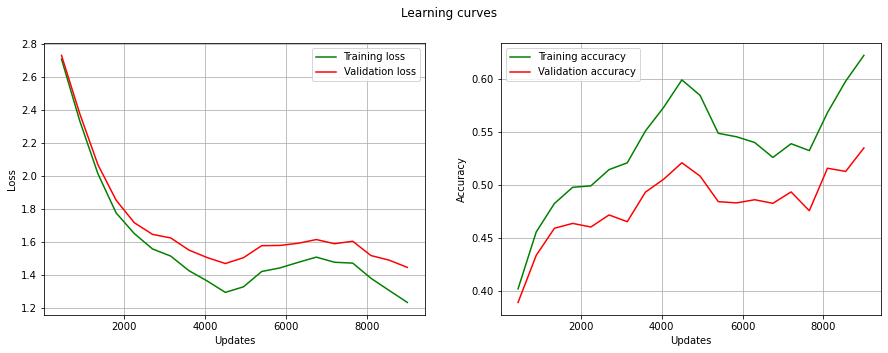

In [55]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

In [57]:
print(acc_val[-1])

0.535


#### Training a 9 layer network

In [58]:
hidden_dim = [50,30,20,20,10,10,10,10]

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Train the network
W, b, γ, β, mean_avg, var_avg, updates, acc_train, loss_train, acc_val, loss_val= \
    MiniBatchGD(X_train, Y_train, y_train, GDparams, λoptimal, W, b, γ, β, 
                X_val, Y_val, y_val, batch_norm=True)

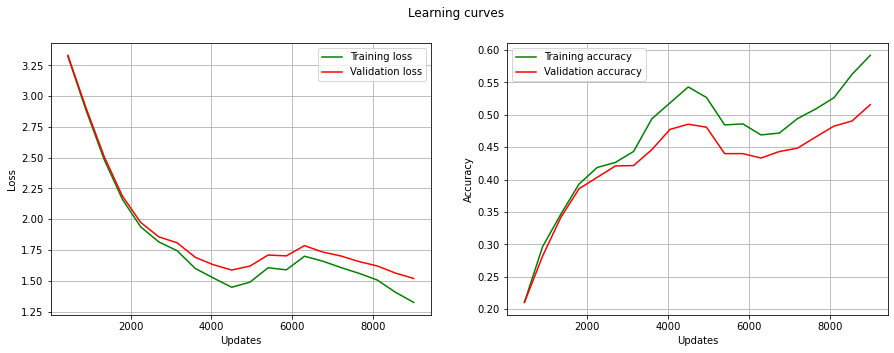

In [59]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

In [61]:
print(acc_val[-1])

0.5156


#### Coarse-to-fine random search to set λ

In [35]:
# Function that performs mini batch GD with different values of λ
def λ_search(λ_list, X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, W, b, γ, β):
    
    λs = []
    loss_train_λ = []
    acc_train_λ = []
    loss_val_λ = []
    acc_val_λ = []
    
    # iterate through different values of λ
    for λ in tqdm(λ_list):
        
        W, b, γ, β, mean_avg, var_avg, updates, acc_train, loss_train, acc_val, loss_val = \
            MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, γ, β, 
                        X_val, Y_val, y_val, batch_norm=True)
        
        # Saving metrics   
        λs.append(λ)
        loss_train_λ.append(loss_train[-1])
        acc_train_λ.append(acc_train[-1])
        loss_val_λ.append(loss_val[-1])
        acc_val_λ.append(acc_val[-1])
            
        
    return λs, loss_train_λ, acc_train_λ, loss_val_λ, acc_val_λ

In [36]:
np.random.seed(0)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(10)
list_λs_coarse = list(10**l)
list_λs_coarse.sort()
list_λs_coarse

[0.000341795291206101,
 0.0004950159553733192,
 0.0005627932047415164,
 0.0015119336467640998,
 0.0015676677195506057,
 0.002576638574613588,
 0.0038333321561566606,
 0.007257005721594274,
 0.03690557729213758,
 0.07155682161754859]

In [37]:
# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Run the search for λ
λs, loss_train_λ, acc_train_λ, loss_val_λ, acc_val_λ = \
    λ_search(list_λs_coarse, X_train, Y_train, y_train, 
             X_val, Y_val, y_val, GDparams, W, b, γ, β)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [03:26<31:00, 206.73s/it]

 20%|██        | 2/10 [06:52<27:29, 206.18s/it]

 30%|███       | 3/10 [10:17<24:00, 205.75s/it]

 40%|████      | 4/10 [13:45<20:38, 206.41s/it]

 50%|█████     | 5/10 [17:21<17:29, 209.94s/it]

 60%|██████    | 6/10 [20:58<14:09, 212.46s/it]

 70%|███████   | 7/10 [24:34<10:40, 213.64s/it]

 80%|████████  | 8/10 [28:03<07:04, 212.07s/it]

 90%|█████████ | 9/10 [31:28<03:29, 209.96s/it]

100%|██████████| 10/10 [34:55<00:00, 209.56s/it]


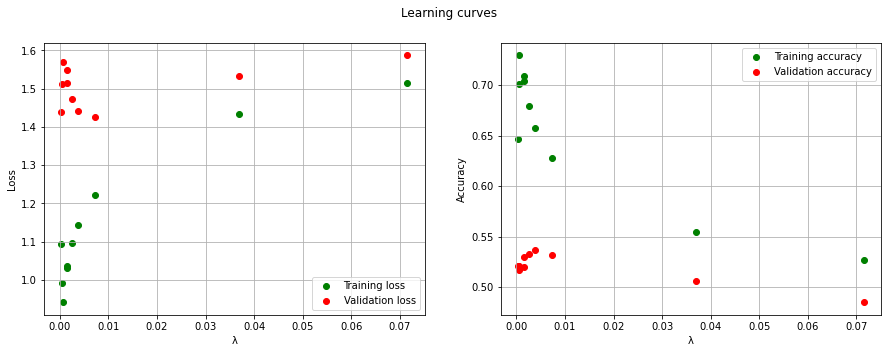

In [45]:
# Plotting performance for each λ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Learning curves')

ax1.scatter(λs, loss_train_λ, label = "Training loss", color = "green")
ax2.scatter(λs, acc_train_λ, label = "Training accuracy", color = "green")
ax1.scatter(λs, loss_val_λ, label = "Validation loss", color = "red")   
ax2.scatter(λs, acc_val_λ, label = "Validation accuracy", color = "red")

ax1.set_xlabel("λ")
ax2.set_xlabel("λ")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")

ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()

In [50]:
max_acc_val = max(acc_val_λ)
best_λ_index = acc_val_λ.index(max_acc_val)
best_λ = λs[best_λ_index]

print("\nBest λ:", best_λ)
print("\nBest accuracy:", max_acc_val)


Best λ: 0.0038333321561566606

Best accuracy: 0.537


#### Optimal λ 3 layer network training

In [47]:
# Define the network parameters
λoptimal = best_λ
GDparams['cycles'] = 3

# Train the network
W, b, γ, β, mean_avg, var_avg, updates, acc_train, loss_train, acc_val, loss_val= \
    MiniBatchGD(X_train, Y_train, y_train, GDparams, λoptimal, W, b, γ, β, 
                X_val, Y_val, y_val, batch_norm=True)

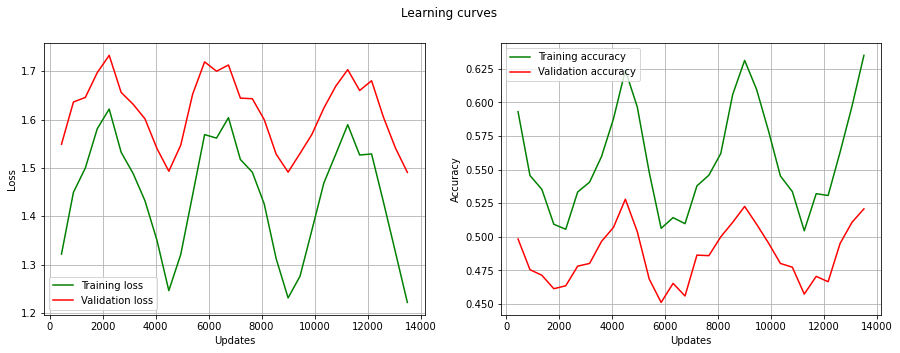

In [48]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

In [49]:
print(acc_val[-1])

0.5208


#### Optimal λ 9 layer network training

In [43]:
hidden_dim = [50,30,20,20,10,10,10,10]

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim)

# Train the network
W, b, γ, β, mean_avg, var_avg, updates, acc_train, loss_train, acc_val, loss_val= \
    MiniBatchGD(X_train, Y_train, y_train, GDparams, λoptimal, W, b, γ, β, 
                X_val, Y_val, y_val, batch_norm=True)

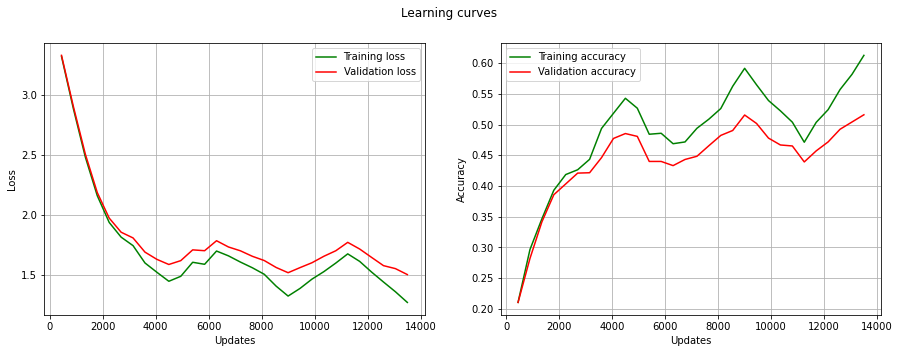

In [44]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

#### 3.6: Pros of Batch Normalization and sensitivity to initialization

In [ ]:
hidden_dim = [50,50]

λ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

#### sigma = 1e-1

In [65]:
sigma = 1e-1

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim, he=False, sigma=sigma)

# Train the network
W, b, updates, acc_train, loss_train, acc_val, loss_val = MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, 
                                                                      X_val=X_val, Y_val=Y_val, y_val=y_val, batch_norm=False)

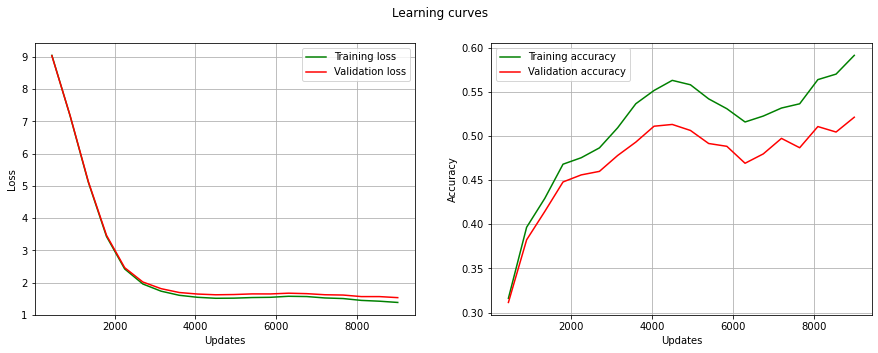

In [66]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

In [67]:
# Train the network
W, b, γ, β, mean_avg, var_avg, updates, acc_train, loss_train, acc_val, loss_val = MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, γ, β, 
                                                                                               X_val, Y_val, y_val, batch_norm=True)

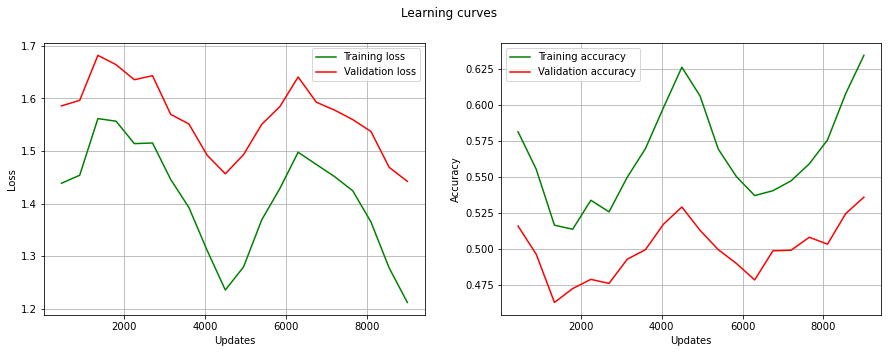

In [68]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

#### sigma = 1e-3

In [69]:
sigma = 1e-3

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim, he=False, sigma=sigma)

# Train the network
W, b, updates, acc_train, loss_train, acc_val, loss_val = MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, 
                                                                      X_val=X_val, Y_val=Y_val, y_val=y_val, batch_norm=False)

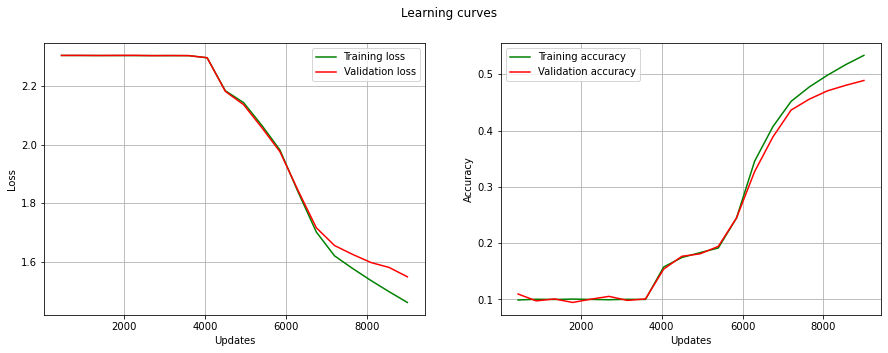

In [70]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

In [71]:
# Train the network
W, b, γ, β, mean_avg, var_avg, updates, acc_train, loss_train, acc_val, loss_val = MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, γ, β, 
                                                                                               X_val, Y_val, y_val, batch_norm=True)

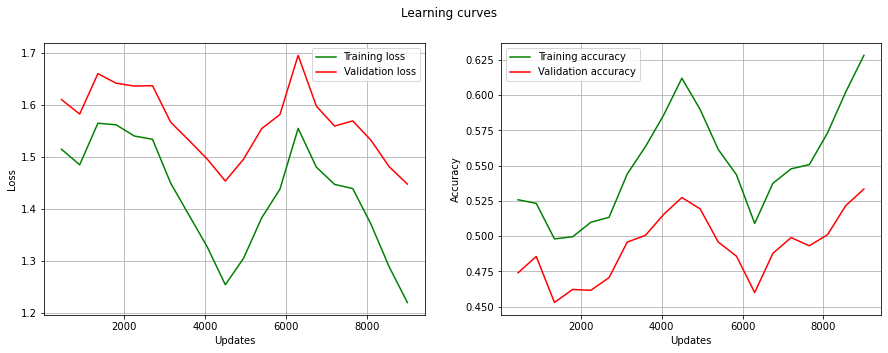

In [72]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

#### sigma = 1e-4

In [73]:
sigma = 1e-4

# Initialize weitghs
W, b, γ, β = initialize_weights(input_dim, hidden_dim, output_dim, he=False, sigma=sigma)

# Train the network
W, b, updates, acc_train, loss_train, acc_val, loss_val = MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, 
                                                                      X_val=X_val, Y_val=Y_val, y_val=y_val, batch_norm=False)

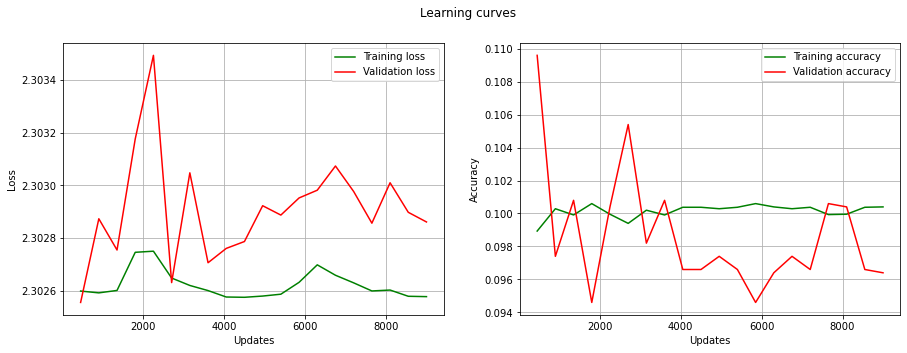

In [74]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)

In [75]:
# Train the network
W, b, γ, β, mean_avg, var_avg, updates, acc_train, loss_train, acc_val, loss_val = MiniBatchGD(X_train, Y_train, y_train, GDparams, λ, W, b, γ, β, 
                                                                                               X_val, Y_val, y_val, batch_norm=True)

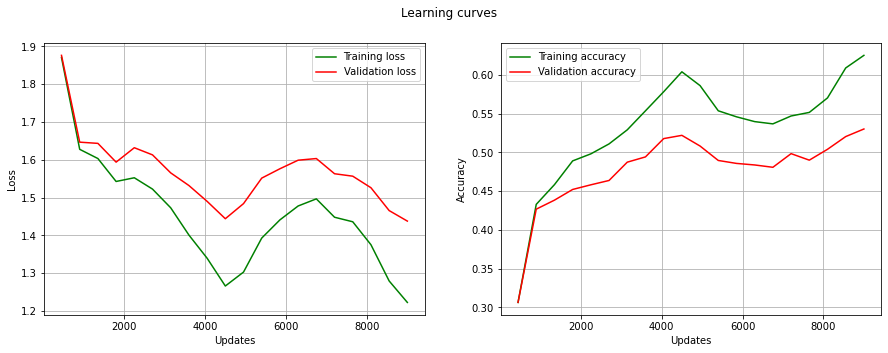

In [76]:
# Plot the learning curve
plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val)